# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [30]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([-0.6269,  1.1781, -0.5234])
Addition: tensor([0.3731, 3.1781, 2.4766])
Mean: tensor(2.)


## Autograd Basics

In [31]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.
### Exercise 1.) part solution

In [32]:
import torch.nn.functional as F

class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)
        mask = (torch.randn(1, 64, 64) > 0).float()

        # Resize to 128x128
        image = F.interpolate(image.unsqueeze(0), size=(128, 128), mode='bilinear')
        mask = F.interpolate(mask.unsqueeze(0), size=(128, 128), mode='nearest')

        return image.squeeze(0), mask.squeeze(0)


## DataLoader

In [33]:
dataset = RandomMRIDataset()
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 128, 128])


## Building a Simple CNN
### 2.) part solution : Add another convolution layer to SimpleCNN and observe how the model size changes.

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),  # NEW LAYER
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

In [35]:
model = SimpleCNN()
print(sum(p.numel() for p in model.parameters()))


39681


## Training Loop Example

In [36]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [37]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

# Implement a small encoder-decoder network (mini U-Net) using conv_block
### 3.) part solution

In [38]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = conv_block(1, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = conv_block(32, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = conv_block(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = conv_block(32, 16)

        self.out = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        m = self.middle(self.pool2(e2))

        d2 = self.up2(m)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.out(d1))


# 4.) part solution : Write a custom Dice Loss function in PyTorch

In [39]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, targets):
        smooth = 1e-6

        preds = preds.view(-1)
        targets = targets.view(-1)

        intersection = (preds * targets).sum()
        dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

        return 1 - dice


# 5.) part solution : Train the CNN on the random dataset and plot the loss curve using matplotlib.

In [40]:
dataset = RandomMRIDataset()
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SimpleCNN()
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(5):
    epoch_loss = 0
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, masks.mean(dim=(2,3), keepdim=True))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.3491
Epoch 2, Loss: 0.3340
Epoch 3, Loss: 0.3339
Epoch 4, Loss: 0.3334
Epoch 5, Loss: 0.3337


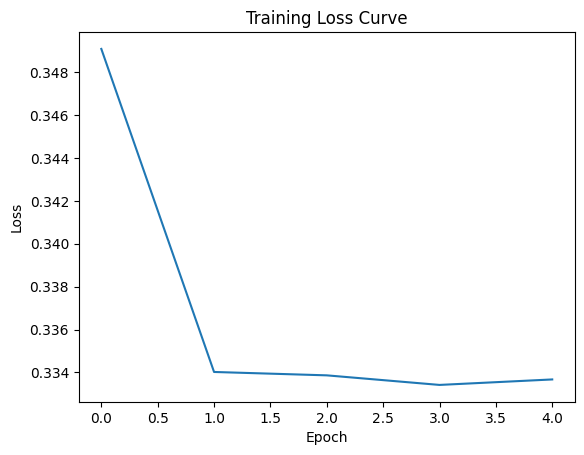

In [41]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  
